# Task 2: Clustering

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

## Loading the RFM model

In [10]:
rfm = pd.read_csv('../dataset/rfm_customer_supermarket_model.csv', sep='\t', index_col=0)
rfm

,monetary,recency,T,frequency,R,F,M,RFMScore
CustomerID,,,,,,,,
12747.0,5.762366,2.079442,5.831882,5.985119,1,3,4,8
12748.0,5.814429,4.584967,5.828946,5.636840,1,2,4,7
12749.0,5.746523,1.098612,5.817111,6.595348,2,4,4,10
12820.0,5.642262,1.098612,5.789960,5.550605,2,2,4,8
12822.0,2.839078,0.000000,4.477337,5.553270,4,2,1,7
...,...,...,...,...,...,...,...,...
18272.0,5.407620,1.609438,5.420535,6.305677,2,4,3,9
18273.0,4.673763,0.693147,5.552960,4.338597,3,1,1,5
18282.0,4.443827,0.000000,5.707110,4.608265,4,1,1,6


## K-means

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [23]:
score = []
for n_clusters in range(2, 10):
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=100)
    clusters = kmeans.fit_predict(rfm)
    score.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(rfm, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.3097132999108547
For n_clusters = 3 The average silhouette_score is : 0.3161880850640452
For n_clusters = 4 The average silhouette_score is : 0.288467035920146
For n_clusters = 5 The average silhouette_score is : 0.28517452422456824
For n_clusters = 6 The average silhouette_score is : 0.29476878843844195
For n_clusters = 7 The average silhouette_score is : 0.2973145907391089
For n_clusters = 8 The average silhouette_score is : 0.30134027246270517
For n_clusters = 9 The average silhouette_score is : 0.2953579132273178


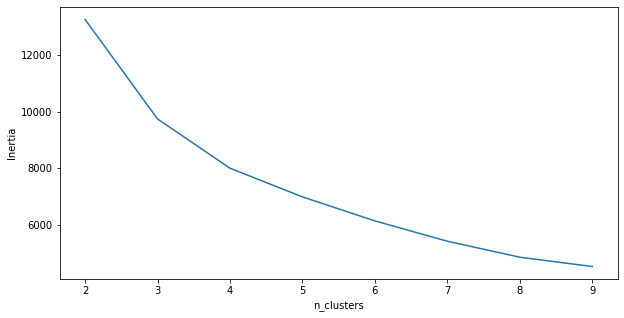

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), score)
plt.ylabel('Inertia')
plt.xlabel('n_clusters');

In [25]:
n_clusters = 2
kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=30)
clusters_customers = kmeans.fit_predict(rfm)
silhouette_avg = silhouette_score(rfm, clusters_customers)
print('score de silhouette: {:<.3f}'.format(silhouette_avg))

score de silhouette: 0.310
